In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ids = test['id']
df = pd.concat([train, test])

In [3]:
df = df.drop(columns = ['id', 'Product ID'])

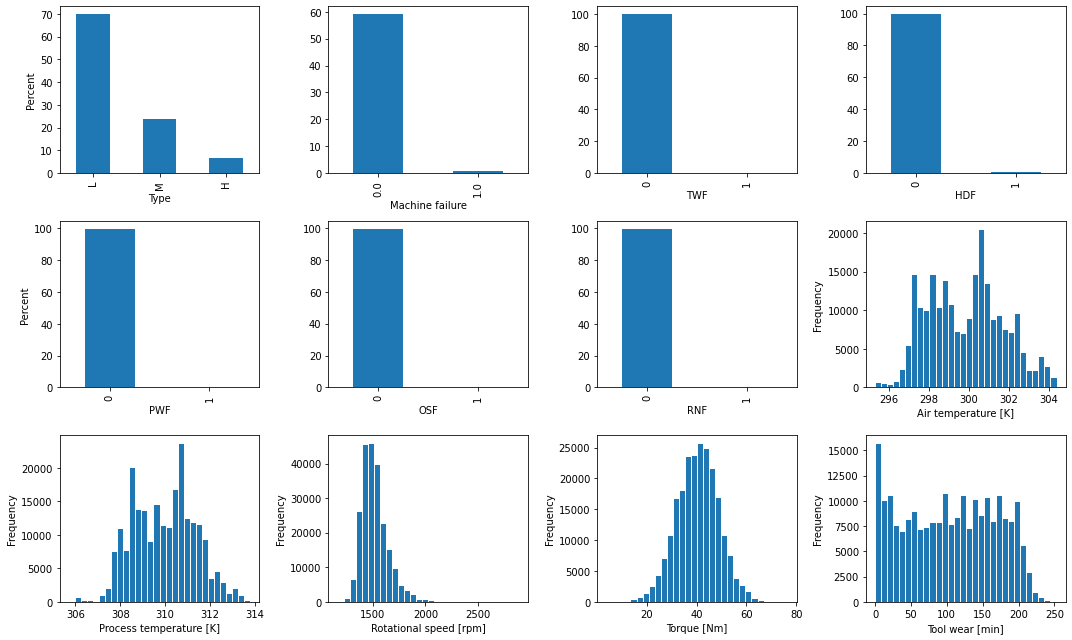

In [4]:
categorical = ['Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
numerical = df.drop(columns = categorical).columns

fig, axes = plt.subplots(3, 4, figsize=(15, 9))
axes = axes.flatten()

for i, col in enumerate(categorical):
    (100* df[col].value_counts() / len(df)).plot.bar(ax = axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percent')
    
for i, col in enumerate(numerical):
    j = i+len(categorical)
    
    df[col].plot.hist(ax = axes[j], bins = 30, edgecolor='white')
    axes[j].set_xlabel(col)
    
plt.tight_layout()

In [5]:
df.columns = ['Type', 'Air temperature', 'Process temperature',
       'Rotational speed', 'Torque', 'Tool wear',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df_dummy = pd.get_dummies(df)

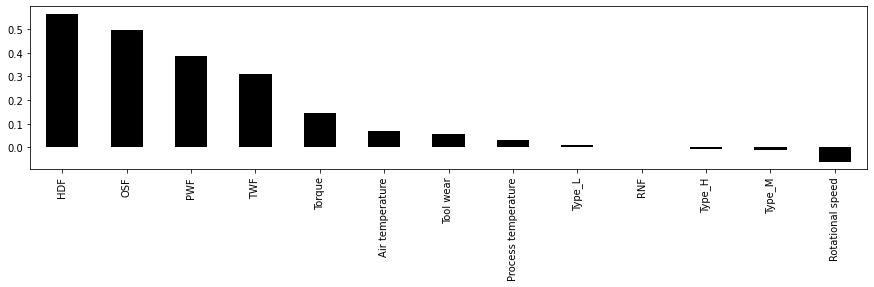

In [6]:
df_dummy.corr()['Machine failure'].sort_values(ascending=False)[1:].plot.bar(figsize=(15,3), cmap='copper')
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = df_dummy.drop(columns='Machine failure')
y = df_dummy['Machine failure']

features = X.columns.values

Scaler = MinMaxScaler()
Scaler.fit(X)
X = Scaler.transform(X)

X = pd.DataFrame(X, columns = features)

X_test = X[len(train):]
X = X.iloc[:len(train)]
y = y.iloc[:len(train)]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [9]:
%%time
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_train_pred = model_lr.predict_proba(X_train)[:, 1]
y_valid_pred = model_lr.predict_proba(X_valid)[:, 1]

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  0.9368843565830778
Validation score:  0.9318392555526347
CPU times: user 1.7 s, sys: 1.14 s, total: 2.85 s
Wall time: 759 ms


In [10]:
%%time
model = XGBClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)[:, 1]
y_valid_pred = model.predict_proba(X_valid)[:, 1]

print("Training score: ", metrics.roc_auc_score(y_train, y_train_pred))
print("Validation score: ", metrics.roc_auc_score(y_valid, y_valid_pred))

Training score:  0.9985206371672222
Validation score:  0.9567352026747313
CPU times: user 18.9 s, sys: 0 ns, total: 18.9 s
Wall time: 4.96 s


In [12]:
final_model = XGBClassifier()
final_model.fit(X, y)
print("Training score: ", metrics.roc_auc_score(y, final_model.predict_proba(X)[:, 1]))
y_test_pred = final_model.predict_proba(X_test)[:, -1]

Training score:  0.9972052321782151


In [13]:
output = pd.DataFrame({'id': ids, 'Machine failure': y_test_pred})

In [14]:
output.to_csv("Submission3.csv", index=False)